# What can be done with text?
- Enrichment of existing text
    - In order to enrich the text it would be cool to know which entities could "lead" somewhere like in rap genious. For this named entities recognition (NER) is a great fit.
- Recommendation
    - In order to make a recommendation where we don't have any data on the user, we can make it based on content of the actual text.  We can process the whole corpus and see which texts are "close" to each other because the use the same vocabulary. We can use this distance information to then

# Get some Data first

In [7]:
import requests
from bs4 import BeautifulSoup

In [8]:
# frontpage_url = "http://www.swissinfo.ch/webservice/swi-eng-2.0/overview"
r = requests.get('https://www.swissinfo.ch/webservice/chatbotize-eng-2.0/detail/44571672/29191706')

In [9]:
text = BeautifulSoup(r.json()["htmldetail"], "lxml").get_text()
text[0:500]

u'    Work permits - SWI swissinfo.ch      Obtaining a permit to work in Switzerland depends on many factors, including where you are from, the skills you have and quotas.Switzerland has a dual system for allowing foreigners to work while in the country. The first concerns citizens from the European Union and/or the European Free Trade Association (EFTA), who are generally allowed to come to Switzerland for three months while they look for work. The period can be extended to six months during an a'

# Named Entities Recognition

In [1]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
            continuous_chunk.append(named_entity)
            current_chunk = []
    return continuous_chunk

In [4]:
r = get_continuous_chunks("Johan Meier kommt aus Deutschland und arbeitet bei der Forschungsabteilung von Microsoft")
r

['Johan Meier', 'Deutschland', 'Forschungsabteilung']

In [11]:
get_continuous_chunks(text)[0:30]

[u'Work',
 u'SWI',
 u'Switzerland',
 u'European Union',
 u'European Free Trade Association',
 u'EFTA',
 u'Switzerland Switzerland',
 u'United Kingdom',
 u'European Union EU',
 u'Brexit',
 u'British',
 u'Switzerland.More',
 u'Switzerland Switzerland Switzerland',
 u'Switzerland State',
 u'Migration',
 u'Switzerland State Bulgaria',
 u'Romania',
 u'Switzerland Swiss',
 u'Romanian',
 u'Bulgarian',
 u'Croatian',
 u'Swiss',
 u'Swiss Switzerland',
 u'State',
 u'Migration Switzerland',
 u'State Migration',
 u'SEM',
 u'Renewal',
 u'Swiss Switzerland Non',
 u'Switzerland Switzerland Swiss']

# See which articles are similar on Front Page

In [50]:
frontpage_url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/overview"
r = requests.get(frontpage_url).json()

In [65]:
#r["page"]["item"][0]["content"][0]

In [63]:
items = []
urls = []
for item in r["page"]["item"][0]["content"]:
    try:
        tmp = requests.get("https://www.swissinfo.ch/webservice/chatbotize-eng-2.0/detail%s" % item["url"])
        text = BeautifulSoup(tmp.json()["htmldetail"], "lxml").get_text()
        items.append(text)
        urls.append(item["canonical"])
        #print("Done: %s" % item["url"])
    except:
        pass

In [60]:
items[1][0:300]

u'    Viola Amherd and Karin Keller-Sutter elected to government  - SWI swissinfo.ch             Viola Amherd (left) and Karin Keller-Sutter are sworn in as cabinet ministers(Keystone)       Viola Amherd and Karin Keller-Sutter have been chosen by parliament to join Switzerland\u2019s seven-person executiv'

In [64]:
urls[1]

u'https://www.swissinfo.ch/eng/politics/cabinet-elections_viola-amherd-elected-to-the-swiss-federal-council/44594062'

### Process Data

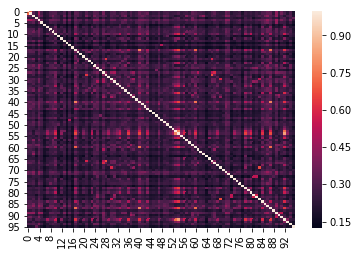

In [73]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns

def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def cluster_items(items, nb_of_clusters=5,mds=False):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(items)
        
        # Show matrix
        pairwise_similarity = tfidf_matrix * tfidf_matrix.T
        ax = sns.heatmap(pairwise_similarity.A)
        ax.plot()
        
        # Clustering
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        if mds:
            return [pairwise_similarity,dict(clusters)]
        else:
            return dict(clusters)


#items = ["Nature is beautiful","I like green apples", "We should protect the trees","Fruit trees provide fruits","Green apples are tasty"]

nclusters= 3
parwise_similarity, clusters = cluster_items(items, nclusters,True)

In [105]:
index = 0
article = urls[index]
article

u'https://www.swissinfo.ch/eng/politics/portrait_two-women-for-government--who-are-switzerland-s-new-ministers-/44596456'

In [106]:
import numpy as np
distances = parwise_similarity.todense()[0].tolist()[index]
closest_match = heapq.nlargest(2, distances)[1]
urls[distances.index(closest_match)]

u'https://www.swissinfo.ch/eng/politics/cabinet-elections_viola-amherd-elected-to-the-swiss-federal-council/44594062'

## Output Clusters for Frontpage

In [72]:
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,item in enumerate(clusters[cluster]):
                print "\turl ",urls[i].split("/")[-3],": ",urls[i].split("/")[-2]

cluster  0 :
	url  politics :  portrait_two-women-for-government--who-are-switzerland-s-new-ministers-
	url  politics :  cabinet-elections_viola-amherd-elected-to-the-swiss-federal-council
	url  society :  climate-change_torrid-time-predicted-for-switzerland-by-2060
	url  business :  banking-in-britain_regulator-warns-banks-over-brexit-moves-out-of-city
	url  politics :  federal-council-elections_what-s-the-essence-of-modern-leadership-
	url  society :  opinion_racism-in-switzerland---an-african-american-expat-s-perspective
	url  business :  withholding-tax_switzerland-likes-to-tax-differently-from-europe
	url  multimedia :  crime-in-3d_solving-crimes-with-the-help-of-virtual-reality-
	url  society :  -weareswissabroad_-our-traditions-keep-us-united-and-define-us-
	url  sci-tech :  cop24_climate-talks-open-amid-post-paris-polemics
	url  eng :  week-in-numbers_-swiss-law-first---maudet-opponents-and-breweries
	url  eng :  compliance_how-do-traders-ensure-due-diligence-in-high-risk-count

## Helping Redactors to tag their content faster with IPTC tags

- https://fasttext.cc/docs/en/cheatsheet.html